# Imports

In [42]:
import logging
import warnings

import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import mlflow

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

# Some data exploration

In [4]:
df = pd.read_csv("../data/training_data.csv")
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,432.475954,289.373016,481.315600,358.755566,802.659004,176.761177,72.648102,720.969179,36.327684,83.768878,...,4.385848,516.789458,19.624422,13.162440,42.351948,35.920392,20.755984,13.814300,384.497136,14.364922
1,517.596250,330.448341,585.920055,22.684031,169.813240,335.601640,284.451476,748.101047,73.701438,358.147215,...,5.563334,2.960064,20.721878,17.740184,1.726915,167.576065,75.492679,2.480979,303.710869,19.984801
2,189.439350,553.888820,165.833790,202.465927,176.695586,321.155049,407.278389,161.245668,282.269025,221.570899,...,4.536947,581.823741,101.695639,0.653592,486.859084,117.491548,6.420465,20.713314,22.651537,12.944351
3,237.307878,195.894881,416.752252,468.729031,611.693517,301.411711,241.880655,49.597044,122.396821,13.828319,...,5.518968,45.014729,196.350455,47.638515,411.414213,67.142022,115.630943,8.927957,388.240433,14.792440
4,602.845256,16.103208,221.759979,345.765574,558.588369,276.704241,408.069566,19.390813,138.769765,146.662193,...,2.136214,133.590430,197.634584,26.278027,111.127557,172.181136,85.869642,30.537857,625.931837,11.802634


In [5]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,468.181612,301.960218,317.132996,283.213456,485.975950,320.953859,217.136330,387.196289,179.485453,196.003058,...,3.372667,479.841915,100.112096,28.334725,277.205999,91.217615,70.927129,27.385266,457.016407,14.631342
std,270.797415,170.691136,176.501920,157.698215,272.594030,185.157189,123.660691,235.131376,104.059309,111.042671,...,1.986369,276.304197,59.149794,16.105155,167.385930,53.950523,40.588905,15.509062,270.650146,5.089503
min,0.916648,0.800119,0.173025,0.308823,0.598527,0.997347,0.402436,0.474825,0.727850,0.264253,...,0.004464,1.706240,0.194306,0.222312,1.726915,0.093789,0.072986,0.101761,0.252919,0.279805
25%,239.330140,157.338244,167.516318,151.302826,250.305362,158.374610,106.876625,195.037853,94.220273,95.052359,...,1.630150,249.560260,48.132939,14.660437,131.516567,44.357970,34.903031,13.815298,221.270792,10.879914
50%,477.750620,303.257176,326.310194,294.574403,493.470486,328.722464,217.098090,364.124238,173.364771,199.587048,...,3.349497,468.536888,100.247827,27.953146,275.950814,87.484343,74.429675,27.766111,462.153497,14.687955
75%,704.650292,448.878174,474.484472,415.806162,720.747672,480.076559,327.411334,588.565017,268.790459,291.546642,...,5.024192,713.291136,149.966755,42.514155,423.110446,137.888018,105.484961,40.402938,688.352373,18.224713
max,940.771543,595.359858,614.271632,549.896216,950.017444,638.199832,426.308251,809.346792,367.084755,384.919108,...,6.859269,979.715063,203.122292,56.467485,566.611509,187.041256,138.675389,53.254740,935.740775,27.360789


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   800 non-null    float64
 1   feature_1   800 non-null    float64
 2   feature_2   800 non-null    float64
 3   feature_3   800 non-null    float64
 4   feature_4   800 non-null    float64
 5   feature_5   800 non-null    float64
 6   feature_6   800 non-null    float64
 7   feature_7   800 non-null    float64
 8   feature_8   800 non-null    float64
 9   feature_9   800 non-null    float64
 10  feature_10  800 non-null    float64
 11  feature_11  800 non-null    float64
 12  feature_12  800 non-null    float64
 13  feature_13  800 non-null    float64
 14  feature_14  800 non-null    float64
 15  feature_15  800 non-null    float64
 16  feature_16  800 non-null    float64
 17  feature_17  800 non-null    float64
 18  feature_18  800 non-null    float64
 19  feature_19  800 non-null    f

In [7]:
df.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
target        0
dtype: int64

# Data profiling

In [8]:
# Generate the report
profile = ProfileReport(df,title="Multivariate Regression Report")

# Save the report to .html
profile.to_file("multivariate-regression-report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:00<00:00, 1129.58it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

After reviewing the data profiling, we see:
- there are no missing data.
- the data distributions do not have long tails, so there are likely no outliers.
- Furthermore, the correlation matrix shows that the variables `feature_2`, `feature_9`, `feature_11`, and `feature_13` have a high correlation with the target variable.

We will check if we find outliers in the boxplots

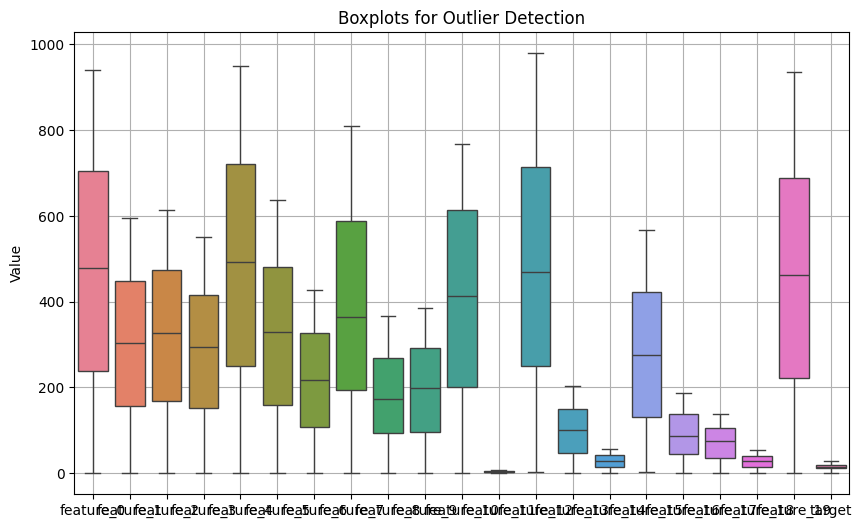

In [9]:
# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient="v")
plt.title("Boxplots for Outlier Detection")
plt.ylabel("Value")
plt.grid(True)
plt.show()

We confirm there are no outliers

# Preprocessing

After the EDA, we see that the data doesn't really require very strict preprocessing. That is, we don't have any missing data or outliers, but we do need to apply normalization.

In [10]:
relevant_features = ["feature_2", "feature_9", "feature_11", "feature_13"]
target = "target"

filtered_df = df[relevant_features + [target]]

# no null values found, so we don't need to remove them

# No outliers found, so we don't need to remove them

filtered_df.head()

,feature_2,feature_9,feature_11,feature_13,target
0,481.315600,83.768878,4.385848,19.624422,14.364922
1,585.920055,358.147215,5.563334,20.721878,19.984801
2,165.833790,221.570899,4.536947,101.695639,12.944351
3,416.752252,13.828319,5.518968,196.350455,14.792440
4,221.759979,146.662193,2.136214,197.634584,11.802634


In [11]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df.drop("target", axis=1), filtered_df["target"], test_size=0.2)

In [12]:
# Normalize the data using MinMaxScaler since the columns are not normally distributed, so we need to preserve the distribution
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
X_train_scaled[:5]

array([[0.33335941, 0.92535354, 0.17709374, 0.96861392],
       [0.45445555, 0.27573787, 0.47412903, 0.9628326 ],
       [0.08022612, 0.52458231, 0.42933915, 0.99959337],
       [0.40995878, 0.99402942, 0.25616791, 0.26615411],
       [0.84488077, 0.89432957, 0.12289516, 0.60924656]])

# Model training

For trcking I will use MLflow, so we can keep record of our experiments and choose the best model with the best params later.

Run the following command to launch the mlflow server locally.

`mlflow server --backend-store-uri sqlite:///backend.db`

Then, run 

In [14]:
tracking_uri = "sqlite:///backend.db"
experiment_name = "multivariate-regression-experiment"

In [15]:
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.autolog()
#mlflow.sklearn.autolog()
#mlflow.xgboost.autolog()

2025/07/11 21:52:01 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/11 21:52:01 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/Users/cristian/personal/data_projects/multivariate_regression/multivariate-regression/notebooks/mlruns/1', creation_time=1752287737347, experiment_id='1', last_update_time=1752287737347, lifecycle_stage='active', name='multivariate-regression-experiment', tags={}>

In [24]:
def display_and_log_metrics(model, name_model, developer, X_train_scaled, y_train, X_test_scaled, y_test, df_train, df_test, use_cv=False):
    with mlflow.start_run():
        mlflow.set_tag("model", name_model)
        mlflow.set_tag("developer", developer)

        dataset_train = mlflow.data.from_pandas(df_train, source="train")
        dataset_test = mlflow.data.from_pandas(df_test, source="test")

        mlflow.log_input(dataset=dataset_train, context="training")
        mlflow.log_input(dataset=dataset_test, context="testing")

        y_pred_train = model.predict(X_train_scaled)
        rmse_train = root_mean_squared_error(y_train, y_pred_train)
        r2_train = model.score(X_train_scaled, y_train)

        mlflow.log_metric("rmse_train", rmse_train)
        mlflow.log_metric("r2_train", r2_train)

        logger.info(f"RMSE train: {rmse_train}")
        logger.info(f"R2 train: {r2_train}")

        y_pred_test = model.predict(X_test_scaled)
        rmse_test = root_mean_squared_error(y_test, y_pred_test)
        r2_test = model.score(X_test_scaled, y_test)

        mlflow.log_metric("rmse_test", rmse_test)
        mlflow.log_metric("r2_test", r2_test)

        logger.info(f"RMSE test: {rmse_test}")
        logger.info(f"R2 test: {r2_test}")

        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()

            mlflow.log_params(best_params)

        except AttributeError as e:
            print(e)
        
        # The input example automatically generates a signature
        mlflow.sklearn.log_model(model, name=f"model_{name_model}", input_example=X_train_scaled[0].reshape(1, -1))

        # Plot the predictions vs. actual values
        plt.scatter(y_test, y_pred_test)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Predictions vs. Actual Values")
        plt.show()

In [39]:
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

### Choose model

First, we will test different models. After choosing a model, we can apply search grid

In [40]:
train_df = X_train.copy()
train_df["target"] = y_train.copy()

test_df = X_test.copy()
test_df["target"] = y_test.copy()

#### Linear regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

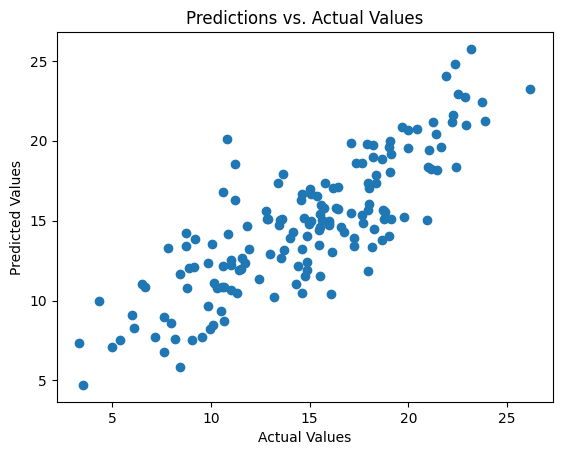

In [43]:
linear = LinearRegression()

linear_search_space = {
    "fit_intercept": Categorical([True, False]),
    "copy_X": Categorical([True, False]),
    "positive": Categorical([True, False])
}

bayes_search_linear = BayesSearchCV(
    estimator=linear,
    search_spaces=linear_search_space,
    scoring="neg_root_mean_squared_error",
    n_iter=25,
    cv=5,
    n_jobs=-1,
    verbose=1,
    #random_state=42
)

bayes_search_linear.fit(X_train_scaled, y_train)

print_best_score_params(bayes_search_linear)

best_linear = bayes_search_linear.best_estimator_

display_and_log_metrics(
    best_linear,
    "LinearRegression",
    "Cristian",
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    train_df, test_df
)